# Hash model
- https://papers.nips.cc/paper/4808-hamming-distance-metric-learning.pdf
- https://arxiv.org/pdf/1702.00758.pdf
- https://stackoverflow.com/questions/37479119/doing-pairwise-distance-computation-with-tensorflow

In [1]:
# TODO: implement HashNet loss from https://arxiv.org/pdf/1702.00758.pdf
# TODO: Use triplets

import tensorflow as tf
import numpy as np

try:
    if global_run_tests:
        pass
except:
    global_run_tests = True
_hashmod_grt = global_run_tests
global_run_tests = False

%run dataset.ipynb
%run visualisation.ipynb
%run augmentator.ipynb

global_run_tests = _hashmod_grt

_hash_model = None

In [88]:
class HashModel():
    ScopeName = "hashing"
    
    def __init__(self, dataset, augmentator, out_dims):
        self.data       = dataset
        self._aug       = augmentator
        self.out_dims   = out_dims
        self._session   = None
        self._graph     = None
        
    def _make_nn(self, images, out_dim, reuse):
        def conv2d_maxpool(inputs, filters, name, reuse, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs      = inputs,
                filters     = filters,
                kernel_size = kernel_size,
                padding     = padding,
                activation  = tf.nn.relu,
                reuse       = reuse,
                name        = name
            )
            l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
            return l
        b = 100.
        l = images
        l = conv2d_maxpool(l, 16,  reuse=reuse, name='conv1')
        l = conv2d_maxpool(l, 32,  reuse=reuse, name='conv2')
        l = conv2d_maxpool(l, 64,  reuse=reuse, name='conv3')
        l = conv2d_maxpool(l, 128, reuse=reuse, name='conv4')
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=100, activation=tf.nn.relu, reuse=reuse, name='fc1')
        l = tf.layers.dense(l, units=out_dim, reuse=reuse, name='fc2')
        l = tf.nn.tanh(l*b)
        return l

    def _make_loss(self, main, same, diff, margin):
        K = self.out_dims
        def haffman_distance(a, b):
            prod = tf.reduce_sum(tf.multiply(a, b), axis=1)
            dist = (K - prod)/2
            return dist
            
        pos_dist = haffman_distance(main, same)
        neg_dist = haffman_distance(main, diff)
        pos_loss = tf.reduce_mean(pos_dist)
        neg_loss = tf.reduce_mean(tf.nn.relu(margin - neg_dist))
        tot_loss = pos_loss + neg_loss
        return tot_loss

    def build(self):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        image_shape = self.data.image_shape
        data_size   = self.data.data_size
        with self._graph.as_default(), tf.name_scope(self.ScopeName), tf.device('/gpu:0'):
            
            # placeholders
            self.img_main_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='main_img')
            self.img_same_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='same_img')
            self.img_diff_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='diff_img')
            self.margin_pl   = tf.placeholder(dtype=tf.float32, name='margin')

            # network
            self.nn_main   = self._make_nn(self.img_main_pl, self.out_dims, reuse=False)
            self.nn_same   = self._make_nn(self.img_same_pl, self.out_dims, reuse=True)
            self.nn_diff   = self._make_nn(self.img_diff_pl, self.out_dims, reuse=True)
            
            # operations
            self.loss_op   = self._make_loss(self.nn_main, self.nn_same, self.nn_diff, self.margin_pl)
            self.train_op  = tf.train.AdamOptimizer(1e-6).minimize(self.loss_op)
            self.init_op   = tf.global_variables_initializer()
            
        self._session = tf.Session(graph=self._graph)
        self._session.run(self.init_op)
        
    def train(self, step_num, batch_size, margin, log_every=10):
        def augment(imgs):
            augmented = np.zeros_like(imgs)
            for i in range(len(imgs)):
                augmented[i] = self._aug.augment(imgs[i])
            return augmented
           
        try:
            losses = []
            for step in range(step_num):
                img_main, img_same, img_diff = self.data.get_next_triplet_batch(batch_size, self._aug.augment)
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.img_main_pl: img_main,
                    self.img_same_pl: img_same,
                    self.img_diff_pl: img_diff,
                    self.margin_pl:   margin,
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num)
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num)

    def save(self, path):
        with self._graph.as_default(), tf.name_scope(self.ScopeName):
            saver = tf.train.Saver()
        saver.save(self._session, path)
        
    def restore(self, path):
        with self._graph.as_default(), tf.name_scope(self.ScopeName):
            saver = tf.train.Saver()
        saver.restore(self._session, path)        
    
    def get_hash(self, imgs, batch_size=100):
        hashes = np.zeros(shape=[len(imgs), self.out_dims])
        bs = min(len(imgs), batch_size)
        for i in range(len(imgs)//bs):
            batch = imgs[i*bs:(i+1)*bs,:]
            hashes[i*bs:(i+1)*bs,:] = self._session.run(self.nn_main, feed_dict = {self.img_main_pl : batch})
        return hashes

## Create model

In [89]:
%%time
def create_model(image_shape, data_size, out_dims, aug_num):
    data = Dataset(image_shape)
    data.load(_dataset_path, data_size)
    aug  = Augmentator(cache_size = aug_num)
    
    model = HashModel(data, aug, out_dims)
    model.build()
    return model, data

if global_run_tests:
    _hash_model, _data = create_model(
        image_shape = [128,128,1],
        data_size   = 1000,
        out_dims    = 4096,
        aug_num     = 0)

CPU times: user 4.24 s, sys: 120 ms, total: 4.36 s
Wall time: 4.32 s


## Train model

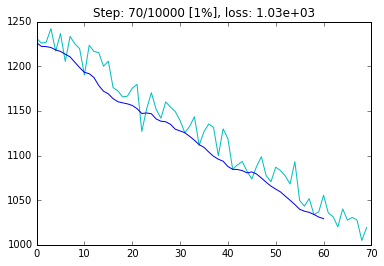

In [ ]:
%%time
def test_train_model(model, step_num, batch_size, margin):
    model.train(step_num=step_num, batch_size=batch_size, margin=margin)
    model.save("data/hash_model/001/")
    
if global_run_tests:
    test_train_model(
        model         = _hash_model,
        step_num      = 10000,
        batch_size    = 64,
        margin        = 100)

## Test quality

In [78]:
images = _data.test_images[:100]
outputs = _hash_model.get_hash(images)
aug  = Augmentator(cache_size = 10)
_database = {}

def get_code(v):
    v = (np.sign(v)+1)/2
    c = "".join(["%d" % f for f in v])
    return c
    
for i, output in enumerate(outputs):
    code = get_code(output)
    _database[code] = i

def augment_batch(imgs, rate):
    res = np.zeros_like(imgs)
    for i in range(len(imgs)):
        res[i] = aug.augment(imgs[i], use_cache= False, rate=rate)
    return res

targets = images # augment_batch(images, rate=.5)
outputs = _hash_model.get_hash(targets)
err = 0
N   = len(images)
for i in range(N):
    code = get_code(outputs[i])
    img_id = _database.get(code, None)
    if i!=img_id:
        err += 1
        # print(i, '->', code[:64], "->", img_id)
print("Quality: %.1f%%" % ((N-err)/N*100))

Quality: 100.0%


## Restore model

In [24]:
def restore_model(image_shape, data_size, out_dims, aug_num, margin, path):
    model,data = create_model(image_shape, data_size, out_dims, aug_num, margin)
    model.restore(path)
    return model, data
    
_hash_model, _data = restore_model(
    image_shape = [128,128,1],
    data_size   = 100,
    out_dims    = 4096,
    aug_num     = 10,
    margin      = 200,
    path        = "data/hash_model/001/")

INFO:tensorflow:Restoring parameters from data/hash_model/001/
